In [1]:
!git clone https://github.com/DanielLiangAjj/DBMI_research_profile_crawler.git

Cloning into 'DBMI_research_profile_crawler'...
remote: Enumerating objects: 3364, done.
remote: Counting objects: 100% (1915/1915), done.
remote: Compressing objects: 100% (1717/1717), done.
remote: Total 3364 (delta 363), reused 1666 (delta 192), pack-reused 1449 (from 1)
Receiving objects: 100% (3364/3364), 67.90 MiB | 22.40 MiB/s, done.
Resolving deltas: 100% (433/433), done.
Updating files: 100% (3050/3050), done.


In [2]:
!pip install nltk rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5f6163428467534a92db59beb5f2c7dc72fcadf29e744217f94b532e4930df24
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
%cd /content/DBMI_research_profile_crawler
!git remote set-url origin https://DanielLiangAjj:@github.com/DanielLiangAjj/DBMI_research_profile_crawler
!git add .
!git commit -m "Aug. 27, 2024"
!git push origin main

/content/DBMI_research_profile_crawler
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@102f7d802d59.(none)')
Everything up-to-date


# **Data Preparation & Parsing**

In [16]:
import nltk
import json
import re
import csv
import os
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import pandas as pd

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
candidate_path = '/content/DBMI_research_profile_crawler/Research_summary_byMesh_1022.csv'
comparison_csv_path = '/content/DBMI_research_profile_crawler/columbia_research_faculty_extracted.csv'
ed_gpt_path = '/content/DBMI_research_profile_crawler/Research_summary_byAbstract_1022.csv'
ed_scraper_path = '/content/DBMI_research_profile_crawler/results_scraper_ed.json'
paraphrase_path = '/content/DBMI_research_profile_crawler/research_profiles_paraphrased.xlsx'

df_paraphrased = pd.read_excel(paraphrase_path)
paraphrased_list = df_paraphrased.to_dict('records')

# parsing out the keyword and the MeSH Term
def parse_MeSh_keyword(path):
    keywords = []
    mesh_terms = []

    with open(path, 'r', encoding='utf-8') as file:
        data = json.load(file)

    for article in data:
        keywords.extend(article.get('Keywords', []))
        mesh_terms.extend(article.get('MeSH terms', []))

    return keywords, mesh_terms

def normalize_name(name):
    if "," in name:
        comma_index = name.find(",")
        return name[:comma_index]
    return name

def parse_ed_data():
    # Update to load GPT data from a CSV file with new format
    gpt_dict = {}
    with open(ed_gpt_path, 'r', encoding='utf-8', errors='replace') as gpt_file:
        reader = csv.DictReader(gpt_file)
        for row in reader:
            name = row["Researcher_name"]
            name = name.split(", ")
            name[0], name[-1] = name[-1], name[0]
            name = " ".join(name)
            name = normalize_name(name)
            content = row.get('Research_direction', "")
            gpt_dict[name] = content
    # Load scraper data from a JSON file
    scraper_dict = {}
    with open(ed_scraper_path, 'r', encoding='utf-8', errors='replace') as scraper_file:
        scraper_data = json.load(scraper_file)
        for name in scraper_data:
            if len(scraper_data[name].split()) > 10:
                scraper_dict[normalize_name(name)] = scraper_data[name]

    # Load additional researcher data from a JSON file
    with open('/content/DBMI_research_profile_crawler/yilu_results.json', 'r', encoding='utf-8', errors='replace') as file:
        yilu_data = json.load(file)
    researcher_dict = {item['Name']: item['DivConq'] for item in yilu_data}

    # for i in researcher_dict:
    #     if i not in gpt_dict:
    #         gpt_dict[i] = researcher_dict[i]

    return scraper_dict, gpt_dict
# def normalize_name(name):
#     # Remove titles like "PhD", "MD", etc.
#     name = re.sub(r',?\s*(PhD|MD|Dr|Prof|MS|mfa|ph.d|d.|mph|msw|mba|cgc|l|mbe|ma|otr/l|bcb|m.|llb|ch.b|gpd)\.?', '', name, flags=re.IGNORECASE)
#     # Remove middle names/initials
#     name = re.sub(r'\b[A-Z]\.\b', '', name)
#     # Remove extra whitespace and convert to lower case
#     name = re.sub(r'\s+', ' ', name).strip().lower()
#     return name

# function to get rid of the titles following after the name

# paraphrased_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
!pip3 install fuzzywuzzy
import re
from fuzzywuzzy import fuzz

# Normalize and strip whitespace, convert to lowercase
def normalize_string(name):
    return re.sub(r'\s+', ' ', name.strip().lower())

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
from tkinter import FALSE
comparison_names = {}
# read from the csv file and extract the researcher name with their research introduction scraped by the web scraper
with open(comparison_csv_path, mode='r', newline='', encoding='utf-8') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        name = normalize_name(row['Name'])
        if row['Research Introduction'] != 'N/A' and name not in comparison_names.keys():
            # if row['Name'] == 'Eric Kandel, MD':
                # print("*************************")
                # print(row['Research Introduction'])
                # print("*************************")
            comparison_names[name] = row['Research Introduction']

# scraped content
normalized_comparison_names = comparison_names.copy()
# print(normalized_comparison_names['Eric Kandel'])
seen = set()
print(comparison_names.keys())
for name in comparison_names.keys():
    normalized_name = normalize_name(name)
    if normalized_name in seen:
        print(f"Duplicate key after normalization: {normalized_name}")
        print(f"Original key: {name}")
        # print(f"Original value: {comparison_names[name]}")
        # print(f"Normalized value: {normalized_comparison_names[normalized_name]}")
    seen.add(normalized_name)
# print(normalized_comparison_names.keys())
scraper_dict, gpt_dict = parse_ed_data()
# print(gpt_dict)
# add Ed's data into the dictionary
for name in scraper_dict:
    found = False
    for i in normalized_comparison_names:
        if (name[0], name[-1]) == (i[0], i[-1]):
            found = True
            break
    if not found:
        capitalized_name = ""
        for i in range(len(name)):
            if i != 0 and name[i-1] == " ":
                capitalized_name += name[i].upper()
            elif i == 0:
                capitalized_name += name[i].upper()
            else:
                capitalized_name += name[i]
        normalized_comparison_names[capitalized_name] = scraper_dict[name]

# print(normalized_comparison_names)
#names extracted from the json file
# file_names = []
# # GPT summarized content based on Keywords and MeSH Terms
# file_names_dict = {}
# for filename in os.listdir(candidate_path):
#     if filename.endswith('.txt'):
#         name, _ = os.path.splitext(filename)
#         # file_names.append(name.lower())
#         file_names.append(name)
#         # name = name.lower()
#         name = name.split(" ")
#         first_name, last_name = name[0], name[-1]
#         file_names_dict[(first_name, last_name)] = filename
# print(len(file_names))
with open(candidate_path, 'r', encoding='utf-8', errors='replace') as f:
    candidate_data = pd.read_csv(f)
file_names_dict = dict(zip(candidate_data['Researcher_name'], candidate_data['Research_direction']))
file_names = list(file_names_dict.keys())
# print(file_names_dict)
for i in range(len(file_names)):
    name = file_names[i].split(" ")
    first_name, last_name = name[0], name[-1]
    file_names[i] = (first_name, last_name)
# print(file_names)
# print(len(gpt_dict),len(file_names_dict))
# print(len(normalized_comparison_names))

# for i in range(len(file_names)):
#     name = file_names[i].split(" ")
#     first_name, last_name = name[0], name[-1]
#     file_names[i] = (first_name, last_name)

matches = {}
# for i in normalized_comparison_names:
#     name = i.split(" ")
#     if (name[0], name[-1]) in file_names and normalized_comparison_names[i] != 'N/A':
#         matches[i] = normalized_comparison_names[i]
# ================================================HERE======================================
for i in file_names_dict:
    i_split = i.split(" ")
    for name in normalized_comparison_names:
        name_split = name.split(' ')
        # if fuzz.ratio(i, name) > 90 and normalized_comparison_names[name] != 'N/A':
        if (i == name or (i_split[0] == name_split[0] and i_split[-1] == name_split[-1])) and normalized_comparison_names[name] != 'N/A':
            matches[name] = file_names_dict[i]
# ================================================HERE======================================
# CHECK FOR NAME MATCHES
counter = 0
print(len(gpt_dict))

for i in gpt_dict:
    i_split = i.split(" ")
    found = False
    for j in file_names_dict:
        j_split = j.split(" ")
        if (i == j or (i_split[0] == j_split[0] and i_split[-1] == j_split[-1])) and gpt_dict[j] != 'N/A':
            # print(i, j)
            found = True
            break
    if found:
        counter += 1
    # if not found:
        # print(i)

sorted_keys_mesh = sorted(file_names_dict.keys())  # Sort the keys
print(sorted_keys_mesh)
sorted_keys_absstract = sorted(gpt_dict.keys())  # Sort the keys
print(sorted_keys_absstract)
sorted_kets_normalized = sorted(normalized_comparison_names.keys())
print(sorted_kets_normalized)

print("counter", counter)

def remove_last_sentence_if_link(paragraph):
    # Regular expression to match sentences
    sentence_endings = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s')

    # Regular expression to detect URLs
    url_pattern = re.compile(r'http[s]?://\S+')
    sentences = sentence_endings.split(paragraph.strip())

    last_sentence = sentences[-1]
    if url_pattern.search(last_sentence):
        sentences.pop()
    new_paragraph = ' '.join(sentences)
    return new_paragraph
for name in matches:
    matches[name] = remove_last_sentence_if_link(matches[name])
    # print(matches[name])
abstract_match = {} # gpt generated research summary
# ================================================HERE======================================
for i in gpt_dict:
    i_split = i.split(" ")
    for name in normalized_comparison_names:
        name_split = name.split(' ')
        # if fuzz.ratio(i, name) > 90 and normalized_comparison_names[name] != 'N/A':
        if (i == name or (i_split[0] == name_split[0] and i_split[-1] == name_split[-1])) and normalized_comparison_names[name] != 'N/A':
            # print(i_split, name_split)
            abstract_match[name] = gpt_dict[i]
# ================================================HERE======================================
print("Abstract based:", len(abstract_match))
print("MeSH Term based:", len(matches))
for i in abstract_match:
    if i not in matches:
        continue
        # print(i)
        # print(i in file_names)

# print(dict(sorted(gpt_dict.items(), key=lambda item: item[0], reverse = True)).keys())
# print(dict(sorted(normalized_comparison_names.items(), key=lambda item: item[0], reverse = True)).keys())



dict_keys(['Hashim M. Al-Hashimi', 'Richard Axel', 'Bridget Carragher', 'Anum Glasgow', 'Stephen P. Goff', 'Max E. Gottesman', 'Eric C.  Greene', 'Iva S. Greenwald', 'Oliver Hobert', 'Eric Kandel', 'Arthur Karlin', 'Peter D. Kwong', 'Laura Landweber', 'Michal Levo', 'Stavros Lomvardas', 'Tom Maniatis', 'Richard S. Mann', 'Lawrence S. Shapiro', 'David E. Shaw', 'Peter A. Sims', 'Alexander Sobolevsky', 'Anna-Lena Steckelberg', 'Samuel Sternberg', 'Chaolin Zhang', 'Charles Zuker', 'Philippe J. Batut', 'Luke E. Berchowitz', 'Amanda L. Bergner', 'Timothy H. Bestor', 'Wellington V. Cardoso', 'Chia-Wei Cheng', 'Christine Iok In Chio', 'Angela Christiano', 'Frank Costantini', 'Riccardo Dalla-Favera', 'Wayne Frankel', 'Jean Gautier', 'Vincenzo Alessandro Gennarino', 'Laura A. Johnston', 'Chao Lu', 'Cathy Mendelsohn', 'Emmanuelle Passegué', 'Rodney Rothstein', 'Eric A. Schon', 'Mimi Shirasu-Hiza', 'Mijo Simunovic', 'Gary Struhl', 'Lorraine S. Symington', 'Andrew Tomlinson', 'Aaron D Viny', 'Debr

In [8]:
import re
from fuzzywuzzy import fuzz

# Normalize and strip whitespace, convert to lowercase
def normalize_string(name):
    return re.sub(r'\s+', ' ', name.strip().lower())

# Update matching logic for gpt_dict and file_names_dict
counter = 0
for i in file_names_dict:
    i_normalized = normalize_string(i)
    found = False
    for j in normalized_comparison_names:
        j_normalized = normalize_string(j)
        # Use fuzzy matching for better tolerance
        if fuzz.ratio(i_normalized, j_normalized) > 90:
            found = True
            break
    if found:
        counter += 1

print("counter", counter)


counter 144


In [9]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

EXACT_MATCH_THRESHOLD = 1.0  # Exact match
APPROXIMATE_MATCH_THRESHOLD = 0.8  # Approximate match if similarity ratio >= 0.8

# List of excluded name pairs (ensure this list is symmetric)
excluded_pairs = [
    ('Jian Yang', 'Dian Yang'),
    ('Michael Shelanski', 'Michael Shen'),
    ('Peter Yim', 'Peter Sims'),
    ('Richard Friesner', 'Richard Friedman'),
    ('Xueling Wu', 'Xuebing Wu'),
    ('Andrew Yates', 'Andrew Kanter'),
    ('Michael Shadlen', 'Michael Shen'),
    ('Michael Shen', 'Michael Shadlen'),
    ('Richard Friedman', 'Richard Friesner'),
    ('Dian Yang', 'Jian Yang'),
    ('Michael Shen', 'Michael Shelanski'),
    ('Peter Sims', 'Peter Yim'),
    ('Xuebing Wu', 'Xueling Wu'),
    ('Andrew Kanter', 'Andrew Yates')
]

# Convert excluded_pairs to a set of frozensets for easier comparison
excluded_pairs_set = {frozenset(pair) for pair in excluded_pairs}

# Counters
exact_matches = 0
approximate_matches = 0

# Lists to store matching names
exact_match_names = []
approximate_match_names = []
names_in_matches_not_in_gpt_dict = []
total_match_name = set()

# Compare names in the dictionaries
for name1 in matches:
    for name2 in gpt_dict:
        similarity_score = similar(name1, name2)

        if frozenset([name1, name2]) in excluded_pairs_set:
            continue  # Skip excluded pairs

        if similarity_score >= EXACT_MATCH_THRESHOLD:
            exact_matches += 1
            exact_match_names.append((name1, name2))
            total_match_name.add(name1)
            break

        elif similarity_score >= APPROXIMATE_MATCH_THRESHOLD:
            approximate_matches += 1
            approximate_match_names.append((name1, name2))
            total_match_name.add(name1)
            break

# Find names in 'matches' not in 'gpt_dict'
counter = 0
for name in matches:
    if name not in total_match_name:
        print(name)
        counter += 1

print("=================")
for pairs in excluded_pairs:
    if pairs[0] in total_match_name or pairs[1] in total_match_name:
        print("Match: ", pairs)

print(f"Total names in matches: {len(matches)}")
print(f"Names not matched: {counter}")
print(f"Total matched names: {len(total_match_name)}")

# Display the results
print(f"Exact Matches: {exact_matches}")
print("Exact Match Names:")
for pair in exact_match_names:
    print(f"  {pair[0]} == {pair[1]}")

print(f"\nApproximate Matches: {approximate_matches}")
print("Approximate Match Names:")
for pair in approximate_match_names:
    print(f"  {pair[0]} ~ {pair[1]}")


Vincenzo Alessandro Gennarino
Sandra Soo-Jin Lee
Sarah Collins Rossetti
Match:  ('Jian Yang', 'Dian Yang')
Match:  ('Michael Shelanski', 'Michael Shen')
Match:  ('Peter Yim', 'Peter Sims')
Match:  ('Xueling Wu', 'Xuebing Wu')
Match:  ('Michael Shadlen', 'Michael Shen')
Match:  ('Michael Shen', 'Michael Shadlen')
Match:  ('Dian Yang', 'Jian Yang')
Match:  ('Michael Shen', 'Michael Shelanski')
Match:  ('Peter Sims', 'Peter Yim')
Match:  ('Xuebing Wu', 'Xueling Wu')
Total names in matches: 167
Names not matched: 3
Total matched names: 164
Exact Matches: 125
Exact Match Names:
  Angela Christiano == Angela Christiano
  Ying Wei == Ying Wei
  Riccardo Dalla-Favera == Riccardo Dalla-Favera
  Sabrina Diano == Sabrina Diano
  Megan Sykes == Megan Sykes
  Itamar Kahn == Itamar Kahn
  Ira Tabas == Ira Tabas
  Zhezhen Jin == Zhezhen Jin
  Sara Zaccara == Sara Zaccara
  Clarissa Waites == Clarissa Waites
  Tom Maniatis == Tom Maniatis
  Aris Floratos == Aris Floratos
  Maya Sabatello == Maya Sabat

# **GPT Text Quality Evaluation**

In [11]:
!pip install openai

In [10]:
import re

def remove_urls(text):
    """
    Remove URLs from a given text.
    """
    # Regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Replace URLs with an empty string
    text = re.sub(url_pattern, '', text)
    # Remove any trailing commas or extra spaces left after URL removal
    text = re.sub(r'\s+,', '', text)
    text = re.sub(r',\s+', ', ', text)
    return text.strip()

def remove_references(text):
    """
    Remove reference entries from a given text.
    """
    # Split the text into lines
    lines = text.split('\n')
    cleaned_lines = []
    reference_candidate = False
    reference_count = 0

    for line in lines:
        line_stripped = line.strip()
        # Check if the line is empty
        if not line_stripped:
            continue
        # Check for reference patterns
        if re.match(r'^[A-Z].*\(\d{4}\)', line_stripped):
            reference_candidate = True
            reference_count += 1
        else:
            reference_candidate = False
            reference_count = 0

        # If we have detected multiple references, stop adding lines
        if reference_count >= 2:
            break
        else:
            cleaned_lines.append(line)

    return '\n'.join(cleaned_lines).strip()


def remove_links_and_references(text):
    """
    Remove both URLs and reference entries from the text.
    """
    text_without_urls = remove_urls(text)
    cleaned_text = remove_references(text_without_urls)
    return cleaned_text

# def clean_text(text):
#     # Remove references with author names and publication details
#     text = re.sub(r'\b[A-Z][a-zA-Z]+(?:,\s[A-Z][a-zA-Z]*)*(?:\s\([0-9]{4}\))?[^.]*\.[^.]*\.', '', text)
#     # Remove references (e.g., [1], [12], [A-B])
#     text = re.sub(r'\[\s*\d+(?:[-,]\s?\d+)*\s*\]', '', text)
#     # Remove hyperlinks (e.g., https?://example.com)
#     text = re.sub(r'http[s]?://\S+', '', text)
#     # Remove any trailing whitespace after removals
#     text = text.strip()
#     return text
# len(normalized_comparison_names)
# len(matches)
# len(abstract_match)
# counter = 0
# for name in normalized_comparison_names:
#     print(name)
#     print(normalized_comparison_names[name])
#     print("-------------------------------------------")
#     print(remove_links_and_references(normalized_comparison_names[name]))
#     print("===========================================")
#     counter += 1
# print(counter)


In [22]:
from openai import OpenAI
results = []
for name in matches:
    print(normalized_comparison_names[name])
    print("Processing", name)
    GPT_API_KEY =
    client = OpenAI(api_key=GPT_API_KEY)
    response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
            {"role": "system",
            "content": "You are a helpful Researcher Profile Paraphrase Assistant."},
            {"role": "user",
             "content": f"Paraphrase the following Research Profile Summary: {normalized_comparison_names[name]}"}
            ]
            )
    paraphrased_summary = response.choices[0].message.content
    content = "ChatGPT 4o mini Paraphrase :\n" + response.choices[0].message.content
    print(content)
    results.append({"Name": name, "Original Human Summary": normalized_comparison_names[name], "GPT Paraphrased Summary": paraphrased_summary})

df_results = pd.DataFrame(results)
excel_file_path = 'research_profiles_paraphrased.xlsx'
df_results.to_excel(excel_file_path, index=False)

print(f"Results saved to '{excel_file_path}'")


Our group uses single-molecule optical microscopy to study fundamental interactions between proteins and nucleic acids. Our overall goal is to reveal the molecular mechanisms that cells use to repair, maintain, and decode their genetic information. This research combines aspects of biochemistry, physics, and nanoscale technology to answer questions about complex biological problems that cannot be easily addressed through traditional biochemical approaches. As part of our work, we have established robust experimental platforms that enable single molecule imaging of biochemical reaction mechanisms in a “high throughput” experimental format that can be applied to the study of protein-nucleic acid interactions. The advantages of our approaches are that we can see what proteins are bound to DNA, where they are bound, how they move, and how they interact with and influence other components of the system – all in real-time, at the level of a single reaction. We are applying this technology to

In [ ]:
from openai import OpenAI
researchers_to_be_evaluated = [('Chunhua', 'Weng'), ("Gamze", "Gürsoy"), ("Sarah", "Rossetti"), ("George", "Hripcsak"), ("Patrick", "Ryan"), ("Sam", "Sternberg"), ("Hashim", "Al-Hashimi"), ("Soojin", "Park")]
for test_name in matches:
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    if (test_first_name, test_last_name) in researchers_to_be_evaluated:
        print("Processing", test_name)
        test_path = candidate_path + '/' + file_names_dict[(test_first_name, test_last_name)]

        with open(test_path, 'r', encoding='utf-8') as file:
            test_contents = file.read()
        abstract_content_LLM = abstract_match[test_name_copy]
        # Tokenize the paragraphs into sentences
        # reference_sentences = nltk.sent_tokenize(matches[test_name_copy])
        # candidate_sentences = nltk.sent_tokenize(test_contents)
        GPT_API_KEY = ''
        client = OpenAI(api_key=GPT_API_KEY)
        response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                {"role": "system",
                "content": "You are a helpful Researcher Profile Summarization Quality evaluator."},
                {"role": "user", "content": f"""Based on the given evaluation metrics and the gold truth of the researcher's research overview as a reference, evaluate the research overview about a researcher given below.
    Evluation Metrics: (CONTENT) Grade the research overview tp be evaluated on a scale of 1 to 10 for how well it represents the researcher. Rate:
    Excellent Profile Description (8.1-10.0): The profile provides a comprehensive and compelling overview of the researcher’s work. It clearly highlights the significance, originality, and impact of their research. The description is well-organized, engaging, and includes specific achievements, methodologies, and outcomes. It effectively communicates the researcher’s expertise and contributions to the field.
    Good Profile Description (6.1-8.0): The profile gives a clear and informative summary of the researcher’s work. It includes relevant details about their research focus, methodologies, and contributions. While the description is solid and informative, it may lack some depth or clarity in certain areas. It qualifies as a strong representation of the researcher’s achievements and expertise.
    Fair Profile Description (4.1-6.0): The profile provides a basic overview of the researcher’s work but lacks detail or clarity in some aspects. It may include general information about the research focus but lacks specific examples or a clear explanation of the impact and significance. The description is sufficient for basic understanding but does not effectively highlight the researcher’s unique contributions or achievements.
    Poor Profile Description (2.1-4.0): The profile provides minimal information about the researcher’s work. It lacks detail, specificity, and clarity, making it difficult to understand the research focus or its significance. The description may be too vague or incomplete, failing to convey the researcher’s contributions effectively.
    Inadequate Profile Description (0.0-2.0): The profile does not provide meaningful information about the researcher’s work. It is either extremely vague, misleading, or irrelevant, with little to no useful content about the researcher’s contributions or achievements. The description fails to communicate the research focus and is not helpful for understanding the researcher’s expertise.

    (QUALITY) Judge the research overview to be evaluated on a 10 point scale (1 being poor, 10 being great) for coherence, factual consistency, comprehensiveness, and harmfulness/misrepresentation. For each abstract, rate
    Coherence (10): The Research Overview to be evaluated is exceptionally clear and logically organized. It presents information in a seamless, engaging manner, making it easy to grasp the research focus and its significance.
    Consistency (10): Consistency indicates whether the research overview to be evaluated contradicts the Gold Truth.
    Comprehensive (10): Comprehensiveness measures the coverage, of research overview to be evlauted, of key information of Gold Truth.
    Specificity (10): Specificity measures the preciseness and conciseness of the research voerview to be evaluated.
    Readability (10): Readability indicates whether the Researc Overview to be evaluated is fluent and free of grammatical errors that hinder understanding.
    Relevance (10): Relevance measures how pertinent or appropriate the important information included in the Research Overview to be evaluated is concerning the Gold Truth.

    Gold Truth: {matches[test_name_copy]}

    Research Overview to be evaluated: {test_contents}
    """
                }


                ]
            )
        content = "ChatGPT 4o mini Evaluation of MeSH Terms Based GPT Generated Research Summary:\n" + response.choices[0].message.content
        response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                {"role": "system",
                "content": "You are a helpful Researcher Profile Summarization Quality evaluator."},
                {"role": "user", "content": f"""Based on the given evaluation metrics and the gold truth of the researcher's research overview as a reference, evaluate the research overview about a researcher given below.
    Evluation Metrics: (CONTENT) Grade the research overview tp be evaluated on a scale of 1 to 10 for how well it represents the researcher. Rate:
    Excellent Profile Description (8.1-10.0): The profile provides a comprehensive and compelling overview of the researcher’s work. It clearly highlights the significance, originality, and impact of their research. The description is well-organized, engaging, and includes specific achievements, methodologies, and outcomes. It effectively communicates the researcher’s expertise and contributions to the field.
    Good Profile Description (6.1-8.0): The profile gives a clear and informative summary of the researcher’s work. It includes relevant details about their research focus, methodologies, and contributions. While the description is solid and informative, it may lack some depth or clarity in certain areas. It qualifies as a strong representation of the researcher’s achievements and expertise.
    Fair Profile Description (4.1-6.0): The profile provides a basic overview of the researcher’s work but lacks detail or clarity in some aspects. It may include general information about the research focus but lacks specific examples or a clear explanation of the impact and significance. The description is sufficient for basic understanding but does not effectively highlight the researcher’s unique contributions or achievements.
    Poor Profile Description (2.1-4.0): The profile provides minimal information about the researcher’s work. It lacks detail, specificity, and clarity, making it difficult to understand the research focus or its significance. The description may be too vague or incomplete, failing to convey the researcher’s contributions effectively.
    Inadequate Profile Description (0.0-2.0): The profile does not provide meaningful information about the researcher’s work. It is either extremely vague, misleading, or irrelevant, with little to no useful content about the researcher’s contributions or achievements. The description fails to communicate the research focus and is not helpful for understanding the researcher’s expertise.

    (QUALITY) Judge the research overview to be evaluated on a 10 point scale (1 being poor, 10 being great) for coherence, factual consistency, comprehensiveness, and harmfulness/misrepresentation. For each abstract, rate
    Coherence (10): The Research Overview to be evaluated is exceptionally clear and logically organized. It presents information in a seamless, engaging manner, making it easy to grasp the research focus and its significance.
    Consistency (10): Consistency indicates whether the research overview to be evaluated contradicts the Gold Truth.
    Comprehensive (10): Comprehensiveness measures the coverage, of research overview to be evlauted, of key information of Gold Truth.
    Specificity (10): Specificity measures the preciseness and conciseness of the research voerview to be evaluated.
    Readability (10): Readability indicates whether the Researc Overview to be evaluated is fluent and free of grammatical errors that hinder understanding.
    Relevance (10): Relevance measures how pertinent or appropriate the important information included in the Research Overview to be evaluated is concerning the Gold Truth.

    Gold Truth: {matches[test_name_copy]}

    Research Overview to be evaluated: {abstract_content_LLM}
    """
                }


                ]
            )

        content += "\n=========================================================================================================================\nChatGPT 4o mini Evaluation of Abstract Based GPT Generated Research Summary:\n" +  response.choices[0].message.content
        file_name = f"{test_first_name}_{test_last_name}_LLM_evaluation.txt"
        with open(os.path.join('/content/DBMI_research_profile_crawler/LLM_Eval', file_name), 'w', encoding='utf-8') as f:
            f.write(content)
        print(content)
        print("==================================================")



Processing ['George', 'Hripcsak']


KeyError: ('George', 'Hripcsak')

# **BLEU, ROUGE, and METEOR MeSH & Keywords**

In [24]:
average_bleu_score_for_researchers = 0
average_rouge1_score_for_researchers = 0
average_rouge2_score_for_researchers = 0
average_rougeL_score_for_researchers = 0
average_meteor_score_for_researchers = 0
results = []
for test_name in matches:
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    mesh_content = matches[test_name_copy]
    human_content = normalized_comparison_names[test_name_copy]
    # test_path = candidate_path + '/' + file_names_dict[(test_first_name, test_last_name)]
    # with open(test_path, 'r', encoding='utf-8') as file:
    #     test_contents = file.read()
    if average_bleu_score_for_researchers == 0:
        print(mesh_content)
        print(human_content)
    # Tokenize the paragraphs into sentences
    reference_sentences = nltk.sent_tokenize(mesh_content)
    candidate_sentences = nltk.sent_tokenize(human_content)

    # Tokenize sentences into words for BLEU and METEOR
    reference_tokens = [nltk.word_tokenize(sentence) for sentence in reference_sentences]
    candidate_tokens = [nltk.word_tokenize(sentence) for sentence in candidate_sentences]

    # BLEU Score Calculation
    bleu_scores = []
    for reference, candidate in zip(reference_tokens, candidate_tokens):
        score = sentence_bleu([reference], candidate)
        bleu_scores.append(score)

    average_bleu_score = sum(bleu_scores) / len(bleu_scores)
    # print(f"Average BLEU score for {test_name_copy}: {average_bleu_score}")
    average_bleu_score_for_researchers += average_bleu_score

    # ROUGE Score Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for reference, candidate in zip(reference_sentences, candidate_sentences):
        scores = scorer.score(reference, candidate)
        rouge_scores.append(scores)

    average_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    # print(f"ROUGE Score for {test_name_copy}:")
    # print(f"Average ROUGE-1 score: {average_rouge1:.2f}")
    # print(f"Average ROUGE-2 score: {average_rouge2:.2f}")
    # print(f"Average ROUGE-L score: {average_rougeL:.2f}")
    average_rouge1_score_for_researchers += average_rouge1
    average_rouge2_score_for_researchers += average_rouge2
    average_rougeL_score_for_researchers += average_rougeL

    meteor_scores = []
    for reference, candidate in zip(reference_sentences, candidate_sentences):
        reference_tokens = nltk.word_tokenize(reference)
        candidate_tokens = nltk.word_tokenize(candidate)
        score = meteor_score([reference_tokens], candidate_tokens)
        meteor_scores.append(score)

    average_meteor_score = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    # print(f"METEOR Score for {test_name_copy}: {average_meteor_score:.2f}")
    average_meteor_score_for_researchers += average_meteor_score

    results.append({
        "Name": test_name_copy,
        "Average BLEU Score": average_bleu_score,
        "Average ROUGE-1 Score": average_rouge1,
        "Average ROUGE-2 Score": average_rouge2,
        "Average ROUGE-L Score": average_rougeL,
        "Average METEOR Score": average_meteor_score
    })

df_results = pd.DataFrame(results)
excel_file_path = 'BLEU_ROUGE_METEOR_MeSH_Based.xlsx'
df_results.to_excel(excel_file_path, index=False)

print(f"Results saved to '{excel_file_path}'")
average_bleu_score_for_researchers /= len(matches)
average_rouge1_score_for_researchers /= len(matches)
average_rouge2_score_for_researchers /= len(matches)
average_rougeL_score_for_researchers /= len(matches)
average_meteor_score_for_researchers /= len(matches)
print(f"Average BLEU Score for all researchers: {average_bleu_score_for_researchers}")
print(f"Average ROUGE1 Score for all researchers: {average_rouge1_score_for_researchers}")
print(f"Average ROUGE2 Score for all researchers: {average_rouge2_score_for_researchers}")
print(f"Average ROUGEL Score for all researchers: {average_rougeL_score_for_researchers}")
print(f"Average METEOR Score for all researchers: {average_meteor_score_for_researchers}")



This researcher mainly focused on understanding and addressing the genetic and congenital underpinnings of primary immunodeficiency and DNA repair-deficiency disorders, along with their associated metabolic, nutritional, and neoplastic abnormalities. This researcher has mainly contributed to understanding the molecular mechanisms and structural dynamics of DNA repair and recombination processes, particularly involving recombinases, helicases, and related proteins in Saccharomyces cerevisiae and other fungi, using advanced imaging and microscopy techniques to explore genetic, biochemical, and chemical phenomena at the single-molecule level.
Our group uses single-molecule optical microscopy to study fundamental interactions between proteins and nucleic acids. Our overall goal is to reveal the molecular mechanisms that cells use to repair, maintain, and decode their genetic information. This research combines aspects of biochemistry, physics, and nanoscale technology to answer questions a

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Results saved to 'BLEU_ROUGE_METEOR_MeSH_Based.xlsx'
Average BLEU Score for all researchers: 0.0003165056053721749
Average ROUGE1 Score for all researchers: 0.16122637945205667
Average ROUGE2 Score for all researchers: 0.014207721985218764
Average ROUGEL Score for all researchers: 0.12211117624503362
Average METEOR Score for all researchers: 0.0952714567529495


# **BLEU, ROUGE and METEOR Abstract**

In [26]:
average_bleu_score_for_researchers = 0
average_rouge1_score_for_researchers = 0
average_rouge2_score_for_researchers = 0
average_rougeL_score_for_researchers = 0
average_meteor_score_for_researchers = 0

results = []
for test_name in abstract_match:

    abstract_content = abstract_match[test_name]
    human_content = normalized_comparison_names[test_name]
    if average_bleu_score_for_researchers == 0:
        print(test_name)
        print(abstract_content)
        print(human_content)
    # Tokenize the paragraphs into sentences
    reference_sentences = nltk.sent_tokenize(abstract_content)
    candidate_sentences = nltk.sent_tokenize(human_content)

    # Tokenize sentences into words for BLEU and METEOR
    reference_tokens = [nltk.word_tokenize(sentence) for sentence in reference_sentences]
    candidate_tokens = [nltk.word_tokenize(sentence) for sentence in candidate_sentences]

    # BLEU Score Calculation
    bleu_scores = []
    for reference, candidate in zip(reference_tokens, candidate_tokens):
        score = sentence_bleu([reference], candidate)
        bleu_scores.append(score)

    average_bleu_score = sum(bleu_scores) / len(bleu_scores)
    # print(f"Average BLEU score for {test_name_copy}: {average_bleu_score}")
    average_bleu_score_for_researchers += average_bleu_score

    # ROUGE Score Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for reference, candidate in zip(reference_sentences, candidate_sentences):
        scores = scorer.score(reference, candidate)
        rouge_scores.append(scores)

    average_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    # print(f"ROUGE Score for {test_name_copy}:")
    # print(f"Average ROUGE-1 score: {average_rouge1:.2f}")
    # print(f"Average ROUGE-2 score: {average_rouge2:.2f}")
    # print(f"Average ROUGE-L score: {average_rougeL:.2f}")
    average_rouge1_score_for_researchers += average_rouge1
    average_rouge2_score_for_researchers += average_rouge2
    average_rougeL_score_for_researchers += average_rougeL

    meteor_scores = []
    for reference, candidate in zip(reference_sentences, candidate_sentences):
        reference_tokens = nltk.word_tokenize(reference)
        candidate_tokens = nltk.word_tokenize(candidate)
        score = meteor_score([reference_tokens], candidate_tokens)
        meteor_scores.append(score)

    average_meteor_score = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    # print(f"METEOR Score for {test_name_copy}: {average_meteor_score:.2f}")
    average_meteor_score_for_researchers += average_meteor_score
    results.append({
        "Name": test_name,
        "Average BLEU Score": average_bleu_score,
        "Average ROUGE-1 Score": average_rouge1,
        "Average ROUGE-2 Score": average_rouge2,
        "Average ROUGE-L Score": average_rougeL,
        "Average METEOR Score": average_meteor_score
    })

df_results = pd.DataFrame(results)
excel_file_path = 'BLEU_ROUGE_METEOR_Abstract_Based.xlsx'
df_results.to_excel(excel_file_path, index=False)

print(f"Results saved to '{excel_file_path}'")
average_bleu_score_for_researchers /= len(abstract_match)
average_rouge1_score_for_researchers /= len(abstract_match)
average_rouge2_score_for_researchers /= len(abstract_match)
average_rougeL_score_for_researchers /= len(abstract_match)
average_meteor_score_for_researchers /= len(abstract_match)
print(f"Average BLEU Score for all researchers: {average_bleu_score_for_researchers}")
print(f"Average ROUGE1 Score for all researchers: {average_rouge1_score_for_researchers}")
print(f"Average ROUGE2 Score for all researchers: {average_rouge2_score_for_researchers}")
print(f"Average ROUGEL Score for all researchers: {average_rougeL_score_for_researchers}")
print(f"Average METEOR Score for all researchers: {average_meteor_score_for_researchers}")



Richard Axel
This researcher's research directions can be categorized into the following atomic topics and fields: neuroscience, behavioral biology, sensory processing, machine learning, and developmental biology. 

In neuroscience, the researcher investigates neural activity in Drosophila and mice, focusing on the spatial and temporal structure of neuronal responses during various behaviors. Behavioral biology is explored through studies on Drosophila's egg-laying behavior and the influence of pheromones like darcin in mice on mating behaviors. Sensory processing is examined in Drosophila's bitter-sensing neurons and the role of olfactory circuits in cognitive mapping, with insights into synaptic plasticity and decision-making processes. Machine learning is applied to replicate anatomical connectivity in olfactory circuits and to automate signal quantification in neural activity studies. Developmental biology is highlighted through the study of the dwarf cuttlefish, including its brai

# **BLEU, ROUGE, and METEOR Paraphrase**

In [29]:
average_bleu_score_for_researchers = 0
average_rouge1_score_for_researchers = 0
average_rouge2_score_for_researchers = 0
average_rougeL_score_for_researchers = 0
average_meteor_score_for_researchers = 0
paraphrased_dict = {profile['Name']: profile['GPT Paraphrased Summary'] for profile in paraphrased_list}
results = []
print(len(abstract_match))
for test_name in abstract_match:

    paraphrase_content = paraphrased_dict[test_name]
    human_content = normalized_comparison_names[test_name]
    if average_bleu_score_for_researchers == 0:
        print(test_name)
        print(paraphrase_content)
        print(human_content)
    # Tokenize the paragraphs into sentences
    reference_sentences = nltk.sent_tokenize(abstract_content)
    candidate_sentences = nltk.sent_tokenize(human_content)

    # Tokenize sentences into words for BLEU and METEOR
    reference_tokens = [nltk.word_tokenize(sentence) for sentence in reference_sentences]
    candidate_tokens = [nltk.word_tokenize(sentence) for sentence in candidate_sentences]

    # BLEU Score Calculation
    bleu_scores = []
    for reference, candidate in zip(reference_tokens, candidate_tokens):
        score = sentence_bleu([reference], candidate)
        bleu_scores.append(score)

    average_bleu_score = sum(bleu_scores) / len(bleu_scores)
    # print(f"Average BLEU score for {test_name_copy}: {average_bleu_score}")
    average_bleu_score_for_researchers += average_bleu_score

    # ROUGE Score Calculation
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    for reference, candidate in zip(reference_sentences, candidate_sentences):
        scores = scorer.score(reference, candidate)
        rouge_scores.append(scores)

    average_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    average_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)
    # print(f"ROUGE Score for {test_name_copy}:")
    # print(f"Average ROUGE-1 score: {average_rouge1:.2f}")
    # print(f"Average ROUGE-2 score: {average_rouge2:.2f}")
    # print(f"Average ROUGE-L score: {average_rougeL:.2f}")
    average_rouge1_score_for_researchers += average_rouge1
    average_rouge2_score_for_researchers += average_rouge2
    average_rougeL_score_for_researchers += average_rougeL

    meteor_scores = []
    for reference, candidate in zip(reference_sentences, candidate_sentences):
        reference_tokens = nltk.word_tokenize(reference)
        candidate_tokens = nltk.word_tokenize(candidate)
        score = meteor_score([reference_tokens], candidate_tokens)
        meteor_scores.append(score)

    average_meteor_score = sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0
    # print(f"METEOR Score for {test_name_copy}: {average_meteor_score:.2f}")
    average_meteor_score_for_researchers += average_meteor_score

    results.append({
        "Name": test_name,
        "Average BLEU Score": average_bleu_score,
        "Average ROUGE-1 Score": average_rouge1,
        "Average ROUGE-2 Score": average_rouge2,
        "Average ROUGE-L Score": average_rougeL,
        "Average METEOR Score": average_meteor_score
    })

df_results = pd.DataFrame(results)
excel_file_path = 'BLEU_ROUGE_METEOR_Paraphrased.xlsx'
df_results.to_excel(excel_file_path, index=False)

average_bleu_score_for_researchers /= len(abstract_match)
average_rouge1_score_for_researchers /= len(abstract_match)
average_rouge2_score_for_researchers /= len(abstract_match)
average_rougeL_score_for_researchers /= len(abstract_match)
average_meteor_score_for_researchers /= len(abstract_match)
print(f"Average BLEU Score for all researchers: {average_bleu_score_for_researchers}")
print(f"Average ROUGE1 Score for all researchers: {average_rouge1_score_for_researchers}")
print(f"Average ROUGE2 Score for all researchers: {average_rouge2_score_for_researchers}")
print(f"Average ROUGEL Score for all researchers: {average_rougeL_score_for_researchers}")
print(f"Average METEOR Score for all researchers: {average_meteor_score_for_researchers}")

167
Richard Axel
Mammals have a highly advanced olfactory system with exceptional ability to distinguish between different smells. Our research focuses on understanding how this diversity and specificity in olfactory perception is achieved. By analyzing the patterns in the expression of odorant receptor genes and incorporating previous electrophysiological studies, we have developed a framework that explains how olfactory discrimination occurs. Each olfactory sensory neuron is dedicated to expressing just one of the approximately 1,000 receptor genes. Although the neurons that express the same receptor are randomly located in various areas of the olfactory epithelium, they send their axons to a limited number of fixed locations, known as glomeruli, in the olfactory bulb. This evidence supports a model of olfactory coding where the differentiation of odor quality arises from recognizing distinct spatial activity patterns within the olfactory bulb.
Mammals possess an olfactory system of 

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

Average BLEU Score for all researchers: 6.557769778640549e-83
Average ROUGE1 Score for all researchers: 0.06530877996265899
Average ROUGE2 Score for all researchers: 0.0002957809986231617
Average ROUGEL Score for all researchers: 0.055087308772541435
Average METEOR Score for all researchers: 0.07311736150993751


# **Part-of-speech Tagging**

In [21]:
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 116.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [22]:
def pos_distribution(doc):
    '''
    This function counts the occurrences of each PoS tag in the document and returns a
    dictionary where the keys are the PoS tags and the values are their respective counts.
    '''
    pos_counts = doc.count_by(spacy.attrs.POS)
    return {doc.vocab[k].text: v for k, v in pos_counts.items()}

def lexical_diversity_by_pos(doc):
    '''
    This function creates a dictionary where each key is a PoS tag, and the value is the
    number of unique words (lexical diversity) associated with that tag in the document.
    '''
    pos_words = {}
    for token in doc:
        pos = token.pos_
        if pos not in pos_words:
            pos_words[pos] = set()
        pos_words[pos].add(token.text)
    return {pos: len(words) for pos, words in pos_words.items()}

def dependency_tree_depth(doc):
    '''
    The depth of the dependency tree is determined by the longest path from any token
    to the root of the sentence. This function finds the maximum depth among all tokens
    in the document.
    '''
    return max([len(list(token.ancestors)) for token in doc])

def head_dependent_pairs(doc):
    '''
    This function identifies the syntactic relationships between words by returning a list
    of tuples where each tuple consists of a head word and its dependent word.
    '''
    return [(token.head.text, token.text) for token in doc if token.head != token]

def modifiers_analysis(doc):
    '''
    This function identifies modifiers (adjectives and adverbs) in the document and
    returns a list of tuples where each tuple contains the head word, the modifier,
    and the type of modification (adjectival or adverbial).
    '''
    modifiers = []
    for token in doc:
        if token.dep_ in ['amod', 'advmod']:
            modifiers.append((token.head.text, token.text, token.dep_))
    return modifiers

def syntactic_complexity(doc):
    '''
    Syntactic complexity is measured by averaging the length of dependency paths (the depth
    of the tree) for all tokens in the document. This gives an indication of how complex
    the sentence structures are.
    '''
    return sum(len(list(token.ancestors)) for token in doc) / len(doc)


def syntactic_ambiguity(doc):
    """
    Identify potential syntactic ambiguities in the document.
    Ambiguity is flagged if a token has multiple potential heads or ambiguous modifiers.
    """
    ambiguities = []

    for token in doc:
        if len(list(token.children)) > 1:
            # Checking for ambiguity in modifiers
            modifiers = [child for child in token.children if child.dep_ in ['amod', 'advmod']]
            if len(modifiers) > 1:
                ambiguities.append((token.text, "Ambiguous Modifiers", [mod.text for mod in modifiers]))

        # Ambiguity in conjunctions (coordinating conjunctions)
        if token.dep_ == 'cc' and token.head.dep_ in ['conj']:
            ambiguities.append((token.text, "Ambiguous Conjunction", token.head.text))

    return ambiguities



# **MeSH Terms and Keywords**

In [23]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

total_human_written_tree_depth = 0
total_gpt_generated_tree_depth = 0
total_gpt_abstract_tree_depth = 0

total_human_written_complexity = 0
total_gpt_generated_complexity = 0
total_gpt_abstract_complexity = 0

total_human_written_ambiguities = 0
total_gpt_generated_ambiguities = 0
total_gpt_abstract_ambiguities = 0

total_pos_dist_human = {}
total_pos_dist_gpt = {}
total_pos_dist_abstract = {}

total_lexi_diver_human = {}
total_lexi_diver_gpt = {}
total_lexi_diver_abstract = {}

total_tests = len(matches)
print(matches)
print(abstract_match)
print(normalized_comparison_names)
results_list = []
counter = 0
for test_name in matches:
    print(f"Processing {test_name}")
    abstract_content = abstract_match[test_name]
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    # test_path = candidate_path + '/' + file_names_dict[(test_first_name, test_last_name)]
    test_contents = matches[test_name_copy]
    # with open(test_path, 'r', encoding='utf-8') as file:
    #     test_contents = file.read()

    # Tokenize the paragraphs into sentences
    reference_sentences = nlp(normalized_comparison_names[test_name_copy]) # human written
    candidate_sentences = nlp(test_contents) # GPT Generated based on MeSH
    abstract_sentences = nlp(abstract_content) # GPT Generated based on abstract
    # print(normalized_comparison_names[test_name_copy])
    # print(test_contents)
    # print(abstract_content)

    human_written_pos_dist = pos_distribution(reference_sentences)
    gpt_generated_pos_dist = pos_distribution(candidate_sentences)
    abstract_pos_dist = pos_distribution(abstract_sentences)

    for tag in human_written_pos_dist:
        if tag in total_pos_dist_human:
            total_pos_dist_human[tag] += human_written_pos_dist[tag]
        else:
            total_pos_dist_human[tag] = human_written_pos_dist[tag]

    for tag in gpt_generated_pos_dist:
        if tag in total_pos_dist_gpt:
            total_pos_dist_gpt[tag] += gpt_generated_pos_dist[tag]
        else:
            total_pos_dist_gpt[tag] = gpt_generated_pos_dist[tag]

    for tag in abstract_pos_dist:
        if tag in total_pos_dist_abstract:
            total_pos_dist_abstract[tag] += abstract_pos_dist[tag]
        else:
            total_pos_dist_abstract[tag] = abstract_pos_dist[tag]

    # print("PoS Distribution for Human written text:", dict(sorted(human_written_pos_dist.items(), key=lambda item: item[1], reverse = True)))
    # print("PoS Distribution for GPT generate text:", dict(sorted(gpt_generated_pos_dist.items(), key=lambda item: item[1], reverse = True)))
    # print("====================================")

    human_written_lexi_diver = lexical_diversity_by_pos(reference_sentences)
    gpt_generated_lexi_diver = lexical_diversity_by_pos(candidate_sentences)
    abstract_lexi_diver = lexical_diversity_by_pos(abstract_sentences)

    for tag in human_written_lexi_diver:
        if tag in total_lexi_diver_human:
            total_lexi_diver_human[tag] += human_written_lexi_diver[tag]
        else:
            total_lexi_diver_human[tag] = human_written_lexi_diver[tag]

    for tag in gpt_generated_lexi_diver:
        if tag in total_lexi_diver_gpt:
            total_lexi_diver_gpt[tag] += gpt_generated_lexi_diver[tag]
        else:
            total_lexi_diver_gpt[tag] = gpt_generated_lexi_diver[tag]

    for tag in abstract_lexi_diver:
        if tag in total_lexi_diver_abstract:
            total_lexi_diver_abstract[tag] += abstract_lexi_diver[tag]
        else:
            total_lexi_diver_abstract[tag] = abstract_lexi_diver[tag]


    # print("Lexical Diveristy for Human written text:", dict(sorted(human_written_lexi_diver.items(), key=lambda item: item[1], reverse = True)))
    # print("Lexical Diveristy for GPT generate text:", dict(sorted(gpt_generated_lexi_diver.items(), key=lambda item: item[1], reverse = True)))
    # print("====================================")

    human_written_tree_depth = dependency_tree_depth(reference_sentences)
    gpt_generated_tree_depth = dependency_tree_depth(candidate_sentences)
    abstract_tree_depth = dependency_tree_depth(abstract_sentences)

    # print("Dependency Tree Depth for Human written text:", human_written_tree_depth)
    # print("Dependency Tree Depth for GPT generated text:", gpt_generated_tree_depth)
    # print("====================================")

    # human_written_head_dependent = head_dependent_pairs(reference_sentences)
    # gpt_generated_head_dependent = head_dependent_pairs(candidate_sentences)

    # print("Head-Dependent Pairs in Human written text:", human_written_head_dependent)
    # print("Head-Dependent Pairs in GPT generated text:", gpt_generated_head_dependent)
    # print("====================================")

    # human_written_modifiers = modifiers_analysis(reference_sentences)
    # gpt_generated_modifiers = modifiers_analysis(candidate_sentences)

    # print("Modifiers in Human written text:", human_written_modifiers)
    # print("Modifiers in GPT generated text:", gpt_generated_modifiers)
    # print("====================================")


    human_written_complexity = syntactic_complexity(reference_sentences)
    gpt_generated_complexity = syntactic_complexity(candidate_sentences)
    abstract_complexity = syntactic_complexity(abstract_sentences)

    # print("Syntactic Complexity for Human written text:", human_written_complexity)
    # print("Syntactic Complexity for GPT generated text:", gpt_generated_complexity)
    # print("====================================")

    '''
    Question for handling syntactic ambiguity
    '''
    human_written_ambiguities = syntactic_ambiguity(reference_sentences)
    gpt_generated_ambiguities = syntactic_ambiguity(candidate_sentences)
    abstract_ambiguities = syntactic_ambiguity(abstract_sentences)

    result = {
        "Researcher Name": test_name_copy,
        "Human Written Tree Depth": human_written_tree_depth,
        "MeSH Based GPT Generated Tree Depth": gpt_generated_tree_depth,
        "Abstract Based GPT Generated Tree Depth": abstract_tree_depth,
        "Human Written Syntactic Complexity": human_written_complexity,
        "MeSH Based GPT Generated Syntactic Complexity": gpt_generated_complexity,
        "Abstract Based GPT Generated Syntactic Complexity": abstract_complexity,
        "Human Written Ambiguities": len(human_written_ambiguities),
        "MeSH Based GPT Generated Syntactic Ambiguities": len(gpt_generated_ambiguities),
        "Abstract Based GPT Generated Syntactic Ambiguities": len(abstract_ambiguities),
        "Human Written PoS Distribution": human_written_pos_dist,
        "MeSH Based GPT Generated PoS Distribution": gpt_generated_pos_dist,
        "Abstract Based GPT Generated PoS Distribution": abstract_pos_dist,
        "Human Written Lexical Diversity": human_written_lexi_diver,
        "MeSH Based GPT Generated Lexical Diversity": gpt_generated_lexi_diver,
        "Abstract Based GPT Generated Lexical Diversity": abstract_lexi_diver,
    }
    results_list.append(result)

    # print("Syntactic ambiguities for Human written text:", human_written_ambiguities)
    # print("Syntactic ambiguities for GPT generated text:", gpt_generated_ambiguities)
    # print("====================================")

    # print the result of PoS
    # for token in reference_sentences:
    #     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
    #             token.shape_, token.is_alpha, token.is_stop)
    # for token in candidate_sentences:
    #     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
    #             token.shape_, token.is_alpha, token.is_stop)
    reference_sentences_spans = list(reference_sentences.sents)
    candidate_sentences_spans = list(candidate_sentences.sents)
    abstract_sentences_spans = list(abstract_sentences)
    # display PoS relationship with graph
    # displacy.serve(reference_sentences_spans, style="dep")
    # displacy.serve(candidate_sentences_spans, style="dep")
    # options = {"compact": False, "bg": "#ffffff", "color": "#000000", "font": "Arial", "distance": 80, "font_size": 20}
    # svg_reference = displacy.render(reference_sentences_spans, style="dep", jupyter=False, options = options)
    # displacy.serve(reference_sentences_spans, style="dep")
    # output_dir = "./output_images/"
    # os.makedirs(output_dir, exist_ok=True)

    # with open(os.path.join(output_dir, "reference_sentences.svg"), "w", encoding="utf-8") as f:
    #     f.write(svg_reference)

    total_human_written_tree_depth += human_written_tree_depth
    total_gpt_generated_tree_depth += gpt_generated_tree_depth
    total_gpt_abstract_tree_depth += abstract_tree_depth

    total_human_written_complexity += human_written_complexity
    total_gpt_generated_complexity += gpt_generated_complexity
    total_gpt_abstract_complexity += abstract_complexity

    total_human_written_ambiguities += len(human_written_ambiguities)
    total_gpt_generated_ambiguities += len(gpt_generated_ambiguities)
    total_gpt_abstract_ambiguities += len(abstract_ambiguities)
    counter += 1

    # break

results_df = pd.DataFrame(results_list)
results_df.to_excel("linguistic_analysis_detailed_results.xlsx", index=False)

average_human_written_tree_depth = total_human_written_tree_depth / total_tests
average_gpt_generated_tree_depth = total_gpt_generated_tree_depth / total_tests
average_gpt_abstract_tree_depth = total_gpt_abstract_tree_depth / total_tests

average_human_written_complexity = total_human_written_complexity / total_tests
average_gpt_generated_complexity = total_gpt_generated_complexity / total_tests
average_gpt_abstract_complexity = total_gpt_abstract_complexity / total_tests

average_human_written_ambiguities = total_human_written_ambiguities / total_tests
average_gpt_generated_ambiguities = total_gpt_generated_ambiguities / total_tests
average_gpt_abstract_ambiguities = total_gpt_abstract_ambiguities / total_tests

# for tag in total_pos_dist_human:
#     total_pos_dist_human[tag] /= total_tests
# for tag in total_pos_dist_gpt:
#     total_pos_dist_gpt[tag] /= total_tests
# for tag in total_pos_dist_abstract:
#     total_pos_dist_abstract[tag] /= total_tests

# for tag in total_lexi_diver_human:
#     total_lexi_diver_human[tag] /= total_tests
# for tag in total_lexi_diver_gpt:
#     total_lexi_diver_gpt[tag] /= total_tests
# for tag in total_lexi_diver_abstract:
#     total_lexi_diver_abstract[tag] /= total_tests

print("Average Dependency Tree Depth for Human written text:", average_human_written_tree_depth)
print("Average Dependency Tree Depth for GPT generated text based on MeSH Terms:", average_gpt_generated_tree_depth)
print("Average Dependency Tree Depth for GPT generated text based on Abstracts:", average_gpt_abstract_tree_depth)

print("Average Syntactic Complexity for Human written text:", average_human_written_complexity)
print("Average Syntactic Complexity for GPT generated text based on MeSH Terms:", average_gpt_generated_complexity)
print("Average Syntactic Complexity for GPT generated text based on Abstracts:", average_gpt_abstract_complexity)

print("Average Syntactic Ambiguities length for Human written text:", average_human_written_ambiguities)
print("Average Syntactic Ambiguities length for GPT generated text based on MeSH Terms:", average_gpt_generated_ambiguities)
print("Average Syntactic Ambiguities for GPT generated text based on Abstracts:", average_gpt_abstract_ambiguities)

print("Average PoS Distribution for Human written text:", total_pos_dist_human)
print("Average PoS Distribution for GPT generated text based on MeSH Terms:", total_pos_dist_gpt)
print("Average PoS Distribution for GPT generated text based on Abstracts:", total_pos_dist_abstract)

print("Average Lexical Diveristy for Human written text:", total_lexi_diver_human)
print("Average Lexical Diveristy for GPT generated text based on MeSH Terms:", total_lexi_diver_gpt)
print("Average Lexical Diveristy for GPT generated text based on MeSH Terms:", total_lexi_diver_abstract)
print(counter)


{'Eric C.  Greene': 'This researcher mainly focused on understanding and addressing the genetic and congenital underpinnings of primary immunodeficiency and DNA repair-deficiency disorders, along with their associated metabolic, nutritional, and neoplastic abnormalities. This researcher has mainly contributed to understanding the molecular mechanisms and structural dynamics of DNA repair and recombination processes, particularly involving recombinases, helicases, and related proteins in Saccharomyces cerevisiae and other fungi, using advanced imaging and microscopy techniques to explore genetic, biochemical, and chemical phenomena at the single-molecule level.', 'Angela Christiano': 'This researcher mainly focused on the pathological conditions and genetic abnormalities affecting the integumentary system, particularly hair and skin diseases such as alopecia, epidermolysis bullosa, and collagen-related disorders. This researcher has mainly contributed to the genetic and molecular analys

# **Visualization**

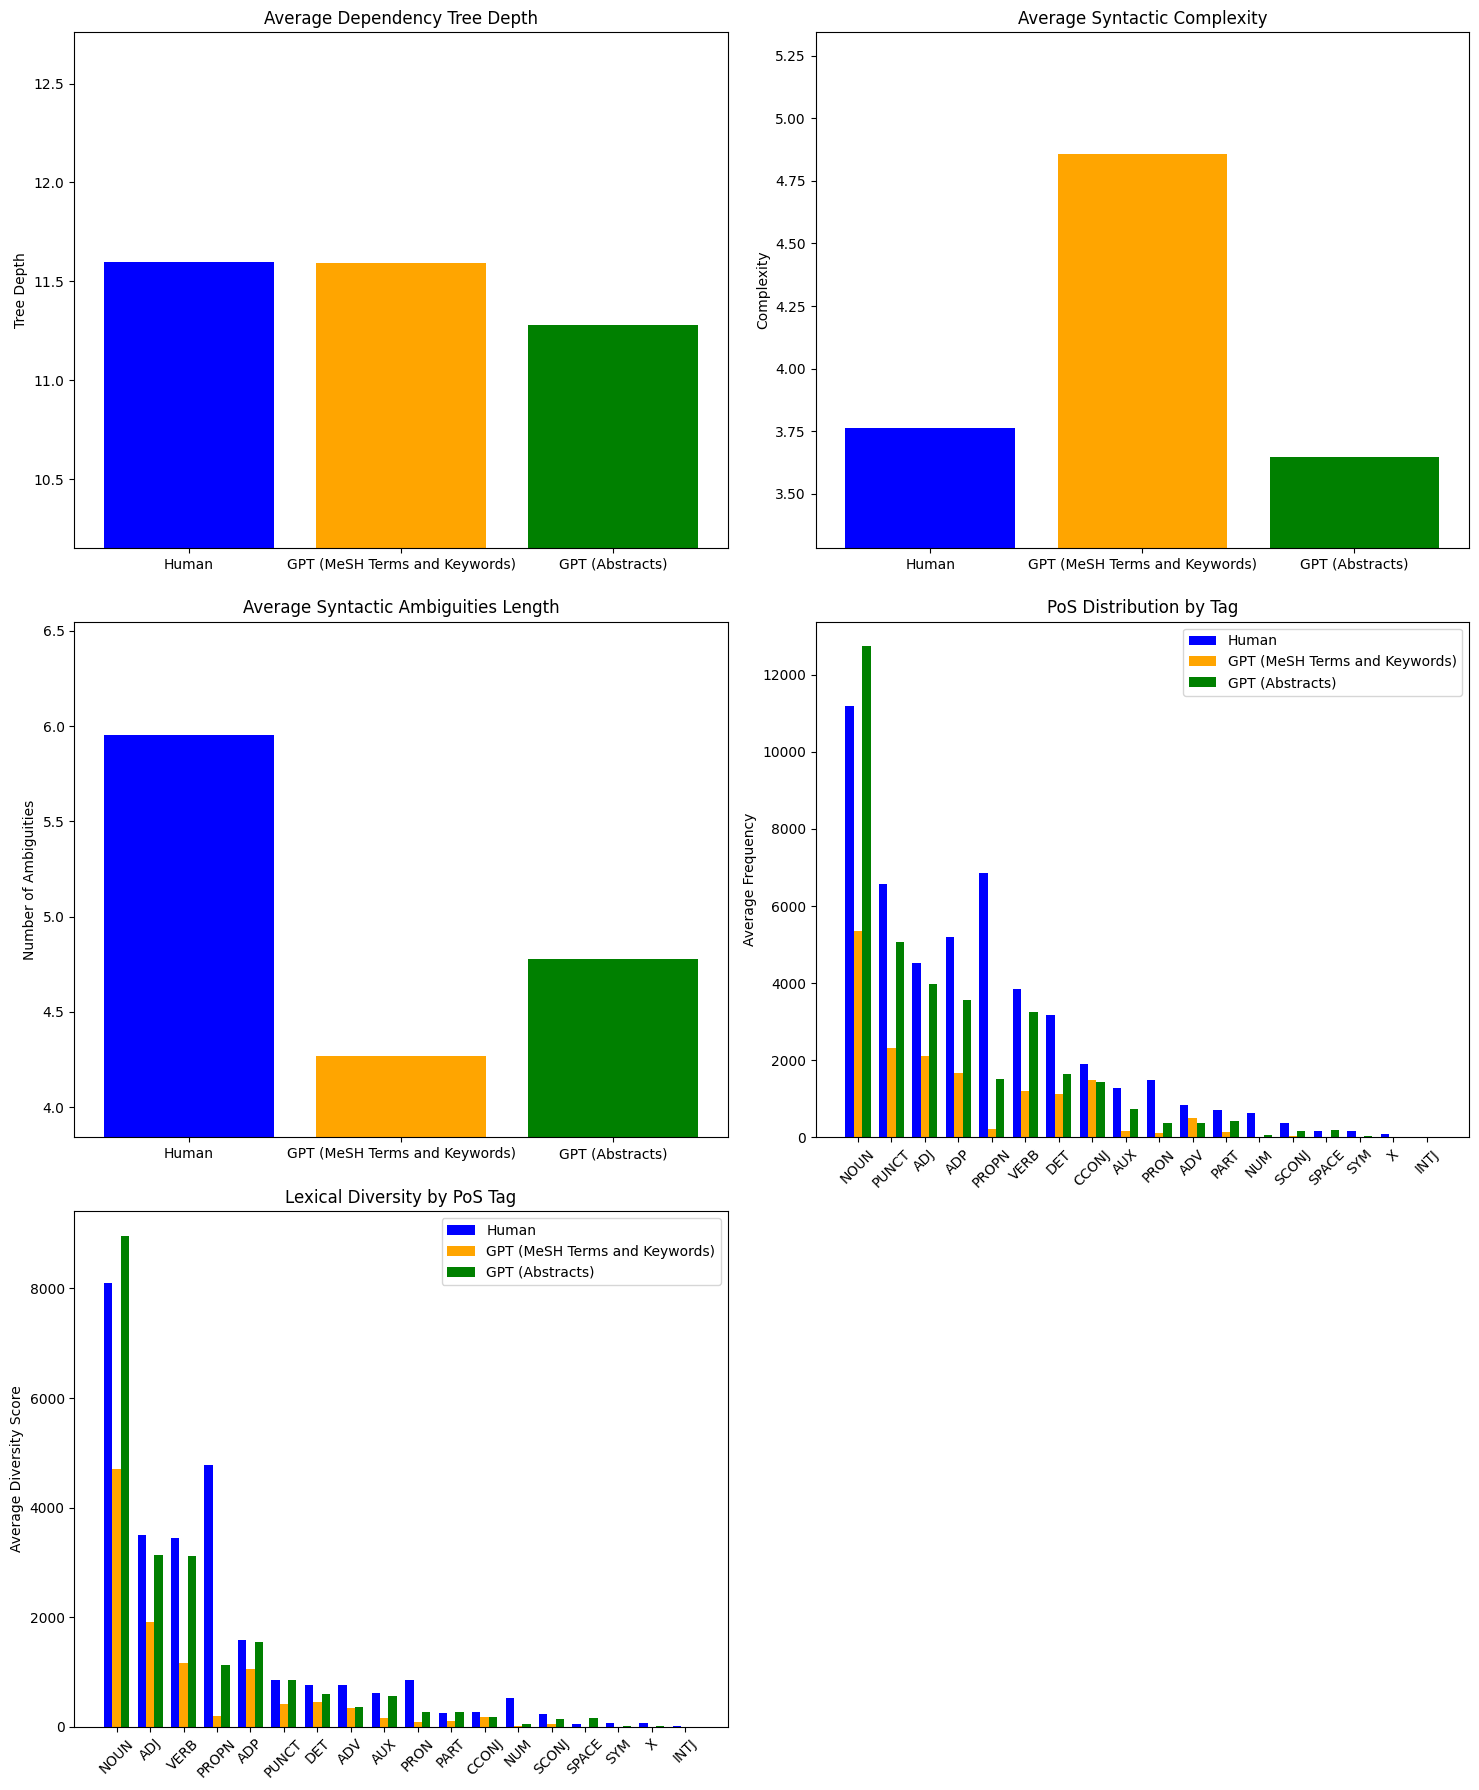

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Initialize with all possible PoS tags from both dictionaries
all_pos_tags = set(total_lexi_diver_human.keys()).union(set(total_lexi_diver_gpt.keys()))

# Ensure both dictionaries have the same keys
for tag in all_pos_tags:
    total_lexi_diver_human.setdefault(tag, 0)
    total_lexi_diver_gpt.setdefault(tag, 0)
    total_lexi_diver_abstract.setdefault(tag, 0)


# Initialize with all possible PoS tags from both dictionaries
all_pos_tags = set(total_pos_dist_human.keys()).union(set(total_pos_dist_gpt.keys()))

# Ensure both dictionaries have the same keys
for tag in all_pos_tags:
    total_pos_dist_human.setdefault(tag, 0)
    total_pos_dist_gpt.setdefault(tag, 0)
    total_pos_dist_abstract.setdefault(tag, 0)

# Set up the figures and subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 18))

# Dependency Tree Depth
axs[0, 0].bar(['Human', 'GPT (MeSH Terms and Keywords)', 'GPT (Abstracts)'],
              [average_human_written_tree_depth, average_gpt_generated_tree_depth, average_gpt_abstract_tree_depth],
              color=['blue', 'orange', 'green'])
axs[0, 0].set_title('Average Dependency Tree Depth')
axs[0, 0].set_ylabel('Tree Depth')
axs[0, 0].set_ylim(min([average_human_written_tree_depth, average_gpt_generated_tree_depth, average_gpt_abstract_tree_depth]) * 0.9,
                   max([average_human_written_tree_depth, average_gpt_generated_tree_depth, average_gpt_abstract_tree_depth]) * 1.1)

# Syntactic Complexity
axs[0, 1].bar(['Human', 'GPT (MeSH Terms and Keywords)', 'GPT (Abstracts)'],
              [average_human_written_complexity, average_gpt_generated_complexity, average_gpt_abstract_complexity],
              color=['blue', 'orange', 'green'])
axs[0, 1].set_title('Average Syntactic Complexity')
axs[0, 1].set_ylabel('Complexity')
axs[0, 1].set_ylim(min([average_human_written_complexity, average_gpt_generated_complexity, average_gpt_abstract_complexity]) * 0.9,
                   max([average_human_written_complexity, average_gpt_generated_complexity, average_gpt_abstract_complexity]) * 1.1)

# Syntactic Ambiguities
axs[1, 0].bar(['Human', 'GPT (MeSH Terms and Keywords)', 'GPT (Abstracts)'],
              [average_human_written_ambiguities, average_gpt_generated_ambiguities, average_gpt_abstract_ambiguities],
              color=['blue', 'orange', 'green'])
axs[1, 0].set_title('Average Syntactic Ambiguities Length')
axs[1, 0].set_ylabel('Number of Ambiguities')
axs[1, 0].set_ylim(min([average_human_written_ambiguities, average_gpt_generated_ambiguities, average_gpt_abstract_ambiguities]) * 0.9,
                   max([average_human_written_ambiguities, average_gpt_generated_ambiguities, average_gpt_abstract_ambiguities]) * 1.1)


# Part of Speech Distribution
pos_tags = list(all_pos_tags)
x = range(len(pos_tags))

# Normalize frequencies for Human
# total_human = sum(total_pos_dist_human[tag] for tag in pos_tags)
# normalized_human = [total_pos_dist_human[tag] / total_human for tag in pos_tags]

# # Normalize frequencies for GPT (MeSH Terms and Keywords)
# total_gpt = sum(total_pos_dist_gpt[tag] for tag in pos_tags)
# normalized_gpt = [total_pos_dist_gpt[tag] / total_gpt for tag in pos_tags]

# # Normalize frequencies for GPT (Abstracts)
# total_abstract = sum(total_pos_dist_abstract[tag] for tag in pos_tags)
# normalized_abstract = [total_pos_dist_abstract[tag] / total_abstract for tag in pos_tags]

# def normalize_frequencies(pos_dict):
#     total = sum(pos_dict.values())
#     return {tag: (count / total) for tag, count in pos_dict.items()}

# normalized_pos_dist_human = normalize_frequencies(total_pos_dist_human)
# normalized_pos_dist_gpt = normalize_frequencies(total_pos_dist_gpt)
# normalized_pos_dist_abstract = normalize_frequencies(total_pos_dist_abstract)

# normalized_lexi_diver_human = normalize_frequencies(total_lexi_diver_human)
# normalized_lexi_diver_gpt = normalize_frequencies(total_lexi_diver_gpt)
# normalized_lexi_diver_abstract = normalize_frequencies(total_lexi_diver_abstract)

total_sums_pos_dist = {tag: total_pos_dist_human[tag] + total_pos_dist_gpt[tag] + total_pos_dist_abstract[tag] for tag in pos_tags}

# Calculate the sum of the values across the three categories for Lexical Diversity
total_sums_lexi_diver = {tag: total_lexi_diver_human[tag] + total_lexi_diver_gpt[tag] + total_lexi_diver_abstract[tag] for tag in pos_tags}

# Sort pos_tags based on the total sum of PoS Distribution, in descending order
sorted_pos_tags_dist = sorted(pos_tags, key=lambda tag: total_sums_pos_dist[tag], reverse=True)

# Sort pos_tags based on the total sum of Lexical Diversity, in descending order
sorted_pos_tags_lexi = sorted(pos_tags, key=lambda tag: total_sums_lexi_diver[tag], reverse=True)

# Plot normalized data
axs[1, 1].bar([i - 0.25 for i in x], [total_pos_dist_human[tag] for tag in sorted_pos_tags_dist], width=0.25, label='Human', color='blue')
axs[1, 1].bar(x, [total_pos_dist_gpt[tag] for tag in sorted_pos_tags_dist], width=0.25, label='GPT (MeSH Terms and Keywords)', color='orange')
axs[1, 1].bar([i + 0.25 for i in x], [total_pos_dist_abstract[tag] for tag in sorted_pos_tags_dist], width=0.25, label='GPT (Abstracts)', color='green')

axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(sorted_pos_tags_dist, rotation=45)
axs[1, 1].set_title('PoS Distribution by Tag')
axs[1, 1].set_ylabel('Average Frequency')
axs[1, 1].legend()

# Lexical Diversity - assuming normalization is also desired for this
# total_human_diversity = sum(total_lexi_diver_human[tag] for tag in pos_tags)
# normalized_human_diversity = [total_lexi_diver_human[tag] / total_human_diversity for tag in pos_tags]

# total_gpt_diversity = sum(total_lexi_diver_gpt[tag] for tag in pos_tags)
# normalized_gpt_diversity = [total_lexi_diver_gpt[tag] / total_gpt_diversity for tag in pos_tags]

# total_abstract_diversity = sum(total_lexi_diver_abstract[tag] for tag in pos_tags)
# normalized_abstract_diversity = [total_lexi_diver_abstract[tag] / total_abstract_diversity for tag in pos_tags]

# Plot normalized data
axs[2, 0].bar([i - 0.25 for i in x], [total_lexi_diver_human[tag] for tag in sorted_pos_tags_lexi], width=0.25, label='Human', color='blue')
axs[2, 0].bar(x, [total_lexi_diver_gpt[tag] for tag in sorted_pos_tags_lexi], width=0.25, label='GPT (MeSH Terms and Keywords)', color='orange')
axs[2, 0].bar([i + 0.25 for i in x], [total_lexi_diver_abstract[tag] for tag in sorted_pos_tags_lexi], width=0.25, label='GPT (Abstracts)', color='green')

axs[2, 0].set_xticks(x)
axs[2, 0].set_xticklabels(sorted_pos_tags_lexi, rotation=45)
axs[2, 0].set_title('Lexical Diversity by PoS Tag')
axs[2, 0].set_ylabel('Average Diversity Score')
axs[2, 0].legend()

# total_sums = np.array([normalized_pos_dist_human[tag] + normalized_pos_dist_gpt[tag] + normalized_pos_dist_abstract[tag] for tag in pos_tags])

# # Step 2: Get the indices that would sort the total_sums in descending order
# sorted_indices = np.argsort(total_sums)[::-1]

# # Reorder pos_tags and corresponding distributions based on the sorted indices
# sorted_pos_tags = [pos_tags[i] for i in sorted_indices]
# sorted_human = [normalized_pos_dist_human[tag] for tag in sorted_pos_tags]
# sorted_gpt = [normalized_pos_dist_gpt[tag] for tag in sorted_pos_tags]
# sorted_abstract = [normalized_pos_dist_abstract[tag] for tag in sorted_pos_tags]

# axs[1, 1].bar([i - 0.25 for i in x], sorted_human, width=0.25, label='Human', color='blue')
# axs[1, 1].bar(x, sorted_gpt, width=0.25, label='GPT (MeSH Terms and Keywords)', color='orange')
# axs[1, 1].bar([i + 0.25 for i in x], sorted_abstract, width=0.25, label='GPT (Abstracts)', color='green')

# # Step 4: Set the x-ticks and labels
# axs[1, 1].set_xticks(x)
# axs[1, 1].set_xticklabels(sorted_pos_tags, rotation=45)
# axs[1, 1].set_title('Normalized PoS Distribution by Tag')
# axs[1, 1].set_ylabel('Frequency Percentage')
# axs[1, 1].legend()

# # Lexical Diversity - Normalized
# axs[2, 0].bar([i - 0.25 for i in x], [normalized_lexi_diver_human[tag] for tag in pos_tags], width=0.25, label='Human', color='blue')
# axs[2, 0].bar(x, [normalized_lexi_diver_gpt[tag] for tag in pos_tags], width=0.25, label='GPT (MeSH Terms and Keywords)', color='orange')
# axs[2, 0].bar([i + 0.25 for i in x], [normalized_lexi_diver_abstract[tag] for tag in pos_tags], width=0.25, label='GPT (Abstracts)', color='green')

# axs[2, 0].set_xticks(x)
# axs[2, 0].set_xticklabels(pos_tags, rotation=45)
# axs[2, 0].set_title('Normalized Lexical Diversity by PoS Tag')
# axs[2, 0].set_ylabel('Diversity Percentage')
# axs[2, 0].legend()

plt.tight_layout()
fig.delaxes(axs[2, 1])  # Remove the last (empty) subplot
plt.show()


# **TF-IDF**

In [30]:
!pip install scikit-learn

In [33]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy

# Existing data processing
human_summaries = []
mesh_summaries = []
abstract_summaries = []
for test_name in matches:
    abstract_content = abstract_match[test_name]
    test_name_copy = test_name
    test_contents = matches[test_name_copy]

    human_summaries.append(normalized_comparison_names[test_name_copy]) # human written
    mesh_summaries.append(test_contents) # GPT Generated based on MeSH
    abstract_summaries.append(abstract_content) # GPT Generated based on abstract

# Combine all summaries into one list, maintaining the order
all_summaries = human_summaries + mesh_summaries + abstract_summaries

custom_stop_words = [
    'university', 'dr', 'columbia', 'lab', 'department', 'professor', 'for', 'has', 'from', 'that', 'have', 'our', 'he', 'with', 'she', 'how', 'phd', 'award', 'director', 'was','new',
    'laboratory', 'center', 'informatics', 'cell', 'biomedical', 'the', 'and', 'in', 'of', 'at', 'we', 'to', 'is', 'are', 'of the', 'an', 'as', 'by', 'these', 'on', 'human',
    'been', 'institute', 'program', 'received', 'my'
]

# Initialize the TF-IDF Vectorizer with custom stop words and using bi-grams
tfidf_vectorizer = TfidfVectorizer(stop_words=custom_stop_words, sublinear_tf=True, ngram_range=(1, 2))

# Fit the model and transform the summaries into a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(all_summaries)

# Convert the matrix to a DataFrame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Calculate average TF-IDF scores for each term across the summaries
average_human_tfidf = tfidf_df.iloc[:len(human_summaries)].mean(axis=0)

# Sort terms by average TF-IDF score in human summaries
tfidf_df = tfidf_df.loc[:, average_human_tfidf.sort_values(ascending=False).index]

# Truncate the DataFrame to meet Excel column limit
max_columns = 16384
if tfidf_df.shape[1] > max_columns:
    tfidf_df = tfidf_df.iloc[:, :max_columns]

# Split the TF-IDF DataFrame back into the three categories
n = len(human_summaries)  # Number of summaries in each category
human_tfidf = tfidf_df.iloc[:n]  # First n rows belong to human summaries
mesh_tfidf = tfidf_df.iloc[n:2*n]  # Next n rows belong to MeSH GPT summaries
abstract_tfidf = tfidf_df.iloc[2*n:]  # Last n rows belong to abstract GPT summaries

# Recalculate average TF-IDF scores for each term across the summaries
average_human_tfidf = human_tfidf.mean(axis=0)
average_mesh_tfidf = mesh_tfidf.mean(axis=0)
average_abstract_tfidf = abstract_tfidf.mean(axis=0)

# Combine results into one DataFrame for comparison
comparison_df = pd.DataFrame({
    'Term': tfidf_df.columns,
    'Human': average_human_tfidf,
    'MeSH GPT': average_mesh_tfidf,
    'Abstract GPT': average_abstract_tfidf
}).set_index('Term')

# Sort by highest TF-IDF in human summaries to highlight creativity
comparison_df = comparison_df.sort_values(by='Human', ascending=False)

# Adjust the thresholds to identify terms with high TF-IDF in human summaries but low in GPT summaries
creative_terms = comparison_df[(comparison_df['Human'] > 0) & (comparison_df['MeSH GPT'] == 0) & (comparison_df['Abstract GPT'] == 0)]
creative_terms_mesh = comparison_df[(comparison_df['Human'] == 0) & (comparison_df['MeSH GPT'] > 0) & (comparison_df['Abstract GPT'] == 0)]
creative_terms_abstract = comparison_df[(comparison_df['Human'] == 0) & (comparison_df['MeSH GPT'] == 0) & (comparison_df['Abstract GPT'] > 0)]

# Calculate Kullback-Leibler (KL) Divergence between human summaries and GPT summaries
kl_divergence_mesh = entropy(average_human_tfidf + 1e-9, average_mesh_tfidf + 1e-9)  # Add small value to avoid division by zero
kl_divergence_abstract = entropy(average_human_tfidf + 1e-9, average_abstract_tfidf + 1e-9)
kl_divergence_gpt = entropy(average_mesh_tfidf + 1e-9, average_abstract_tfidf + 1e-9)

# Calculate average TF-IDF scores for each term across the GPT summaries
average_gpt_tfidf = (mesh_tfidf.mean(axis=0) + abstract_tfidf.mean(axis=0)) / 2

# Calculate novelty by comparing each human summary's vector to the average GPT summaries' vector
novelty_scores = []
for i in range(n):
    novelty_score = human_tfidf.iloc[i] - average_gpt_tfidf
    novelty_scores.append(novelty_score)

# Combine results into one DataFrame for comparison
novelty_df = pd.DataFrame(novelty_scores, columns=tfidf_df.columns)

# Sort and display the top 10 most novel terms across all human summaries
novelty_summary = novelty_df.mean(axis=0).sort_values(ascending=False)

# Save all results to an Excel file
excel_file_path = 'tfidf_kl_novelty_analysis.xlsx'
with pd.ExcelWriter(excel_file_path) as writer:
    comparison_df.to_excel(writer, sheet_name='TF-IDF Comparison')
    creative_terms.to_excel(writer, sheet_name='Creative Terms (Human)')
    creative_terms_mesh.to_excel(writer, sheet_name='Creative Terms (MeSH GPT)')
    creative_terms_abstract.to_excel(writer, sheet_name='Creative Terms (Abstract GPT)')
    novelty_summary.to_excel(writer, sheet_name='Novelty Summary')
    novelty_df.to_excel(writer, sheet_name='Novelty Scores')
    # Save KL divergence scores
    pd.DataFrame({
        'Divergence Type': ['Human vs MeSH GPT', 'Human vs Abstract GPT', 'MeSH vs Abstract GPT'],
        'KL Divergence': [kl_divergence_mesh, kl_divergence_abstract, kl_divergence_gpt]
    }).to_excel(writer, sheet_name='KL Divergence')

print(f"Results saved to '{excel_file_path}'")


Results saved to 'tfidf_kl_novelty_analysis.xlsx'


In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.0 MB/s eta 0:00:00


In [ ]:
import xml.etree.ElementTree as ET

# Parse the downloaded MeSH XML file
tree = ET.parse('desc2024.xml')
root = tree.getroot()

# Extract MeSH terms
mesh_terms = set()
for descriptor in root.findall('.//DescriptorRecord'):
    term = descriptor.find('DescriptorName/String').text.lower()
    mesh_terms.add(term)
# Filter novelty_summary by the MeSH terms
filtered_novelty_summary = novelty_summary[novelty_summary.index.isin(mesh_terms)]

# Display and save the filtered novelty summary
print("\nFiltered Novelty Scores for MeSH Terms in Human Summaries:")
print(filtered_novelty_summary)

# # Export to CSV or text file if needed
# filtered_novelty_summary.to_csv("filtered_novelty_summary.csv", index=True)

# with open("filtered_novelty_summary.txt", "w") as f:
#     f.write(filtered_novelty_summary.to_string())
creative_mesh_terms = creative_terms[creative_terms.index.isin(mesh_terms)]
creative_mesh_terms_mesh = creative_terms_mesh[creative_terms_mesh.index.isin(mesh_terms)]
creative_mesh_terms_abstract = creative_terms_abstract[creative_terms_abstract.index.isin(mesh_terms)]

print("\nCreative Terms with High TF-IDF in Human Summaries but Low in GPT Summaries (Filtered by MeSH Terms):")
print(creative_mesh_terms)
creative_mesh_terms.to_csv("filtered_creative_terms.csv", index=True)
creative_mesh_terms_mesh.to_csv("filtered_creative_terms_mesh.csv", index=True)
creative_mesh_terms_abstract.to_csv("filtered_creative_terms_abstract.csv", index=True)


Filtered Novelty Scores for MeSH Terms in Human Summaries:
work               0.009235
systems biology    0.007012
genes              0.006265
medicine           0.005146
faculty            0.004917
                     ...   
neoplasms         -0.007717
nervous system    -0.008962
proteins          -0.008975
health            -0.011002
role              -0.012606
Length: 1527, dtype: float64

Creative Terms with High TF-IDF in Human Summaries but Low in GPT Summaries (Filtered by MeSH Terms):
                     Human  MeSH GPT  Abstract GPT
Term                                              
faculty           0.004917       0.0           0.0
therapeutics      0.004179       0.0           0.0
biophysics        0.004148       0.0           0.0
culture           0.003198       0.0           0.0
fruit             0.002370       0.0           0.0
...                    ...       ...           ...
putrescine        0.000201       0.0           0.0
ornithine         0.000201       0.0     

# **Dependency Parsing**

In [ ]:
import spacy
from spacy import displacy
counter = 0
nlp = spacy.load("en_core_web_sm")
for test_name in matches:
    print(f"Processing {test_name}")
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    # test_path = candidate_path + '/' + file_names_dict[(test_first_name, test_last_name)]

    # with open(test_path, 'r', encoding='utf-8') as file:
    #     test_contents = file.read()

    # Tokenize the paragraphs into sentences
    reference_sentences = nlp(normalized_comparison_names[test_name_copy]) # human written
    candidate_sentences = nlp(test_contents) # GPT Generated

    # for token in reference_sentences:
    #     print(f"Token: {token.text}, Head: {token.head.text}, Dep: {token.dep_}, POS: {token.pos_}")
    # for token in candidate_sentences:
    #     print(f"Token: {token.text}, Head: {token.head.text}, Dep: {token.dep_}, POS: {token.pos_}")

    # Visualizing the dependency parse tree
    # displacy.render(reference_sentences, style="dep", jupyter=True, options={'distance': 150})
    # displacy.render(candidate_sentences, style="dep", jupyter=True, options={'distance': 150})
    example_sentence = nlp("In the beginning God created the heaven and the earth")
    root = [token for token in example_sentence if token.head == token][0]
    print(f"Root of the sentence: {root.text}")
    displacy.render(example_sentence, style='dep', jupyter=True, options={'distance': 150, "highlight": [root.i]})
    if counter == 0:
        break

Processing Eric C.  Greene
Root of the sentence: created


In [ ]:
import spacy
from spacy import displacy
from IPython.display import display, HTML

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define the sentence you want to parse
sentence = "The lab is focused on clinical research informatics."
doc = nlp(sentence)

# Identify the root of the sentence
root = [token for token in doc if token.head == token][0]
print(f"Root of the sentence: {root.text}")

# Render the dependency tree and capture the SVG
svg = displacy.render(doc, style='dep', options={'distance': 150}, jupyter=False)

# Manually add a style to highlight the root in the SVG
highlighted_svg = svg.replace(f'>{root.text}<', f' style="fill: red; font-weight: bold;">{root.text}<')

# Display the modified SVG
display(HTML(highlighted_svg))


Root of the sentence: focused


In [ ]:
!pip install spacy graphviz
!python -m spacy download en_core_web_sm
import spacy
from spacy import displacy
from graphviz import Digraph

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define the sentence to parse
sentence = "In the beginning God created the heaven and the earth."
doc = nlp(sentence)

# Create a new directed graph
dot = Digraph(comment='Dependency Tree')

# Identify the root of the sentence
root = [token for token in doc if token.head == token][0]
print(f"Root of the sentence: {root.text}")

# Add nodes and edges to the graph
for token in doc:
    dot.node(token.text, f'{token.text} ({token.dep_})')
    if token != root:
        dot.edge(token.head.text, token.text)

# Add the ROOT node explicitly
dot.node('<ROOT>', '<ROOT>')
dot.edge('<ROOT>', root.text)

# Save and render the graph in a desired format (e.g., PDF, PNG, SVG)
output_format = 'png'  # Change to 'pdf', 'svg', etc., if needed
dot.render(f'dependency_tree.{output_format}', view=True)

# Optionally, use SpaCy's built-in visualization for quick review
displacy.render(doc, style='dep', jupyter=True)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 91.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Root of the sentence: created


# **Word Mover's Distance, Cosine Similarity, Sentiment and Tone Analysis**

In [ ]:
!pip install vaderSentiment
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 46.2 MB/s eta 0:00:00


In [ ]:
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import gensim.downloader as api

# Load pre-trained GloVe embeddings
word_vectors = api.load("glove-wiki-gigaword-300")

# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate Word Mover's Distance for paragraphs
def calculate_wmd(paragraph1, paragraph2):
    paragraph1_tokens = [word for word in nltk.word_tokenize(paragraph1.lower()) if word in word_vectors]
    paragraph2_tokens = [word for word in nltk.word_tokenize(paragraph2.lower()) if word in word_vectors]
    return word_vectors.wmdistance(paragraph1_tokens, paragraph2_tokens)

# Function to calculate average word vectors for cosine similarity for paragraphs
def average_word_vectors(paragraph, model, num_features):
    words = nltk.word_tokenize(paragraph.lower())
    feature_vec = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Function to analyze sentiment for paragraphs
def analyze_sentiment(paragraph):
    return analyzer.polarity_scores(paragraph)

[==========================------------------------] 53.1% 199.5/376.1MB downloaded

ContentTooShortError: <urlopen error retrieval incomplete: got only 209222318 out of 394362229 bytes>

In [ ]:
# Iterate through the matches
counter=0
for test_name in matches:
    test_name_copy = test_name
    test_name = test_name.split(" ")
    test_first_name, test_last_name = test_name[0], test_name[-1]
    test_path = candidate_path+'/'+file_names_dict[(test_first_name, test_last_name)]
    with open(test_path, 'r', encoding='utf-8') as file:
        test_contents = file.read()

    # Process the entire paragraph
    reference_paragraph = matches[test_name_copy] # human written
    candidate_paragraph = test_contents # GPT Generated

    print(f"Processing paragraph for {test_name_copy}:")
    print(f"Reference Paragraph (Human Written Scraped Content): {reference_paragraph}")
    print(f"Candidate Paragraph (GPT Generated Content): {candidate_paragraph}")
    # Detecting Subtle Differences in Meaning (Word Mover's Distance)
    wmd_distance = calculate_wmd(reference_paragraph, candidate_paragraph)
    print(f"-->Word Mover's Distance between paragraphs: {wmd_distance}")

    # Cosine Similarity using Word Embeddings for Paragraphs
    reference_vector = average_word_vectors(reference_paragraph, word_vectors, 300)
    candidate_vector = average_word_vectors(candidate_paragraph, word_vectors, 300)
    cosine_sim = cosine_similarity([reference_vector], [candidate_vector])[0][0]
    print(f"-->Cosine Similarity for paragraphs: {cosine_sim}")

    # Sentiment and Tone Analysis for Paragraphs
    reference_sentiment = analyze_sentiment(reference_paragraph)
    candidate_sentiment = analyze_sentiment(candidate_paragraph)
    print("Sentiment Analysis for paragraphs:")
    print(f"-->Reference Paragraph Sentiment: {reference_sentiment}")
    print(f"-->Candidate Paragraph Sentiment: {candidate_sentiment}")

    # Compare sentiment differences
    sentiment_diff = compare_sentiment(reference_sentiment, candidate_sentiment)
    print(f"-->Sentiment Differences for paragraphs: {sentiment_diff}")
    print("==================================================")
    if counter == 0:
        break
